# GPcounts applied to scRNA-Seq time series data

Nuha BinTayyash, 2020

GPcounts is a Gaussian process regression package for counts data with negative binomial and zero-inflated negative binomial likelihoods as described in the paper "Non-parametric modelling of temporal and spatial counts data from RNA-seq experiments".


This notebook shows how to fit GPcounts with zero-inflated negative binomial, negative binomial and Gaussian likelihoods using full inference on ScRNA-seq gene expression data in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset to find differentially expressed genes using infer trajectory and compare it with GPcounts with sparse inferece to obtain to obtain computational efficiency.

In [1]:
import pandas as pd
import numpy as np
import random
import gpflow 
from IPython.display import display

Load $\alpha$ gene expression data and pseudotime information

In [2]:
Y = pd.read_csv('../data/normalized_alpha_counts.csv',index_col=[0])
X = pd.read_csv('../data/alpha_time_points.csv',index_col=[0])
X.shape

(328, 1)

In [3]:
from GPcounts.GPcounts_Module import Fit_GPcounts
from helper import plot 

In [4]:
Y = Y.rename( index={'ENSMUSG00000015879': 'Fam184b','ENSMUSG00000059173':'Pde1a'})
genes_name = ['Fam184b','Pde1a']

aE17.5_2_09  aE17.5_2_16  aE17.5_1_11  aE17.5_3_07  aE17.5_4_06  \
Fam184b      0.00000     0.000000          0.0     0.000000     0.000000   
Pde1a       53.19138    33.888555          0.0    63.941424    60.599705   

         aE17.5_3_04  aE17.5_2_11  aE17.5_1_25  aE17.5_4_01  aE17.5_4_03  ...  \
Fam184b     0.000000     0.000000     0.000000     0.000000      0.00000  ...   
Pde1a      40.608317    15.368216    23.786486     3.812432     44.32606  ...   

         aP18_3_12  aP60_1_11  aP60_3_05  aP15_1_15  aP60_1_13  aP60_3_08  \
Fam184b        0.0        0.0        0.0        0.0        0.0  47.446494   
Pde1a          0.0        0.0        0.0        0.0        0.0   0.000000   

         aP60_5_16  aP18_1_17  aP60_1_10  aP60_5_05  
Fam184b        0.0        0.0        0.0        0.0  
Pde1a          0.0        0.0        0.0        0.0  

[2 rows x 328 columns]

Probabilty of zeros in Fam184b and Pde1a genes

In [5]:
Y.loc[genes_name][Y.loc[genes_name] == 0].count(axis=1)/len(Y.columns)

Fam184b    0.859756
Pde1a      0.628049
dtype: float64

## 1. Fit GPcounts with negative binomial likelihood assuming full inference on Fam184b and Pde1a genes

In [6]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],safe_mode = True) 
likelihoods = [ 'Zero_inflated_negative_binomial','Negative_binomial','Gaussian']

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:56<00:00, 28.44s/it]

The results for Zero_inflated_negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -354.498102                    -357.560408   
Pde1a                     -758.198315                    -784.106171   

         log_likelihood_ratio  
Fam184b              3.062307  
Pde1a               25.907856

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:02<00:00,  1.07s/it]

Fam184b


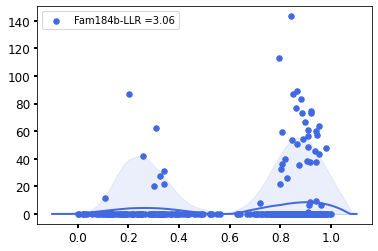

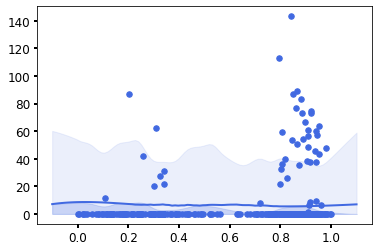

Pde1a


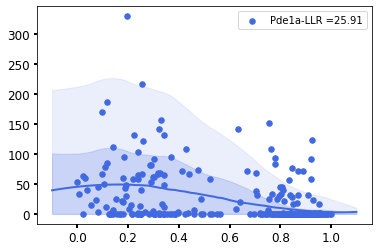

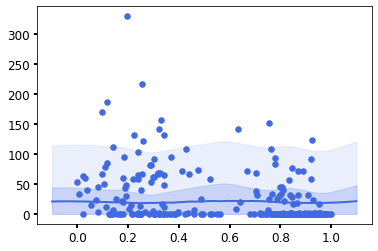

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:10<00:00,  5.00s/it]

The results for Negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -385.423242                    -385.959712   
Pde1a                     -797.367045                    -807.318248   

         log_likelihood_ratio  
Fam184b              0.536470  
Pde1a                9.951203

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:02<00:00,  1.19s/it]

Fam184b


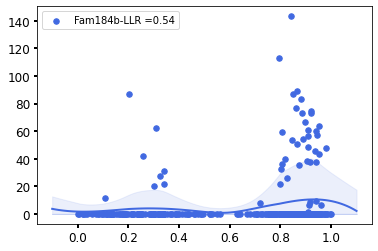

Pde1a


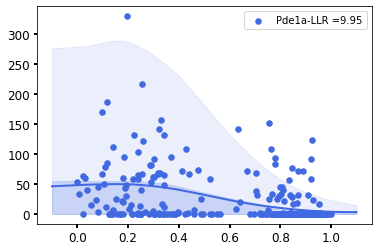

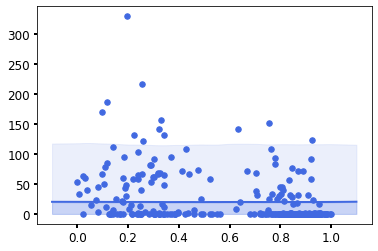

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:01<00:00,  1.18it/s]

The results for Gaussian likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -551.722537                    -554.274201   
Pde1a                     -623.552579                    -663.040231   

         log_likelihood_ratio  
Fam184b              2.551665  
Pde1a               39.487652

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 22.03it/s]

Fam184b


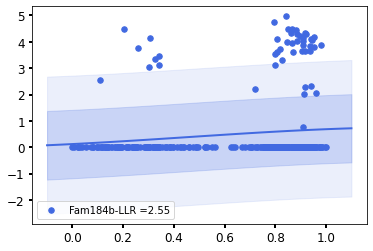

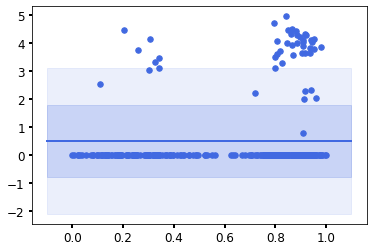

Pde1a


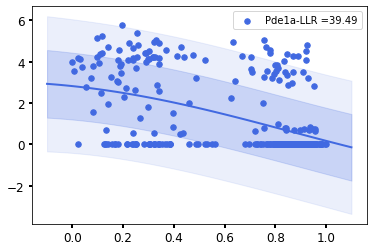

In [7]:
test_name = 'One_sample_test' # name of the test

for likelihood in likelihoods:
    results = gp_counts.One_sample_test(likelihood)
    print('The results for '+likelihood+' likelihood:')
    display(results)
    params = gp_counts.load_predict_models(genes_name,test_name,likelihood) 
    plot(params,X.values,Y.loc[genes_name],results)

## 2. Fit GPcounts with negative binomial likelihood assuming sparse inference to obtain computational efficiency  on Fam184b and Pde1a genes

GPcounts by defaults use $5\%(N^*)$ to set the number of inducing points $M$ and [ $\epsilon- approximate\quad M-DPP$ algorithm](https://github.com/markvdw/RobustGP) to set the location of inducing points $Z$

$^* N = length(X)$

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:12<00:00,  6.31s/it]

The results for Zero_inflated_negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -354.510375                    -357.566388   
Pde1a                     -758.196405                    -784.107533   

         log_likelihood_ratio  
Fam184b              3.056013  
Pde1a               25.911129

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:02<00:00,  1.00s/it]

Fam184b


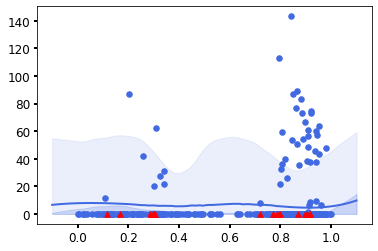

Pde1a


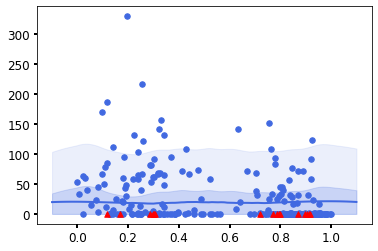

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:05<00:00,  2.90s/it]

The results for Negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -385.423247                    -385.959709   
Pde1a                     -797.366947                    -807.318240   

         log_likelihood_ratio  
Fam184b              0.536462  
Pde1a                9.951293

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:01<00:00,  1.05it/s]

Fam184b


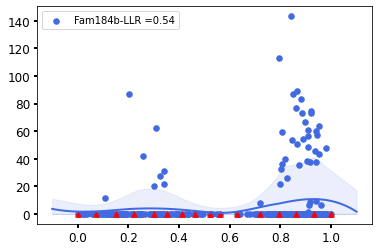

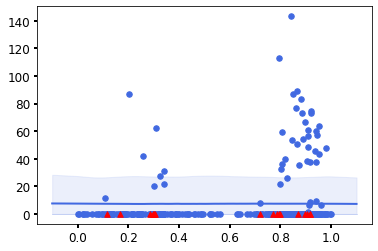

Pde1a


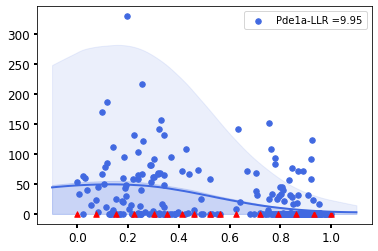

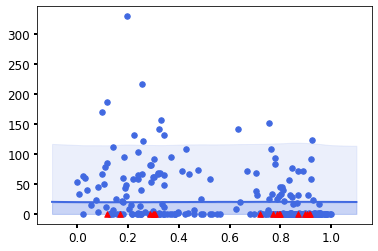

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:02<00:00,  1.16s/it]

The results for Gaussian likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -551.722568                    -554.274207   
Pde1a                     -623.552600                    -663.040234   

         log_likelihood_ratio  
Fam184b              2.551639  
Pde1a               39.487634

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 12.91it/s]

Fam184b


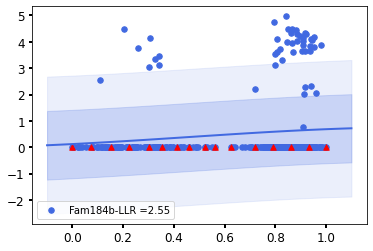

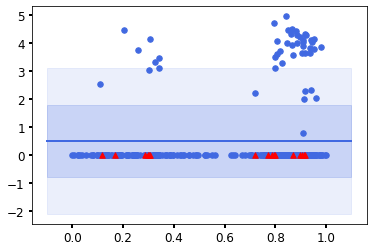

Pde1a


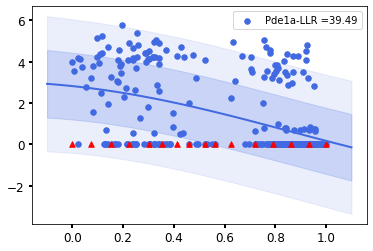

In [8]:
sparse = True 
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],sparse = sparse,safe_mode = True) # use sparse inference

for likelihood in likelihoods:
    results = gp_counts.One_sample_test(likelihood)
    print('The results for '+likelihood+' likelihood:')
    display(results)
    params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
    plot(params,X.values,Y.loc[genes_name],results,sparse) 

To set the number of inducing points $M = \Omega(log(N))$ using the recommend method  use ùúñ‚àíùëéùëùùëùùëüùëúùë•ùëñùëöùëéùë°ùëíùëÄ‚àíùê∑ùëÉùëÉ algorithm to set the location of inducing points  ùëç

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:08<00:00,  4.42s/it]

The results for Zero_inflated_negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -355.432286                    -357.556806   
Pde1a                     -758.196785                    -784.106538   

         log_likelihood_ratio  
Fam184b              2.124519  
Pde1a               25.909753

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:01<00:00,  1.21it/s]

Fam184b


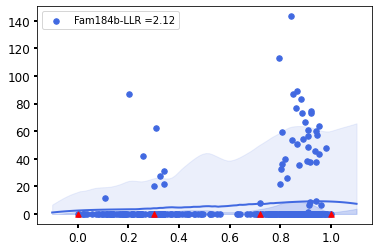

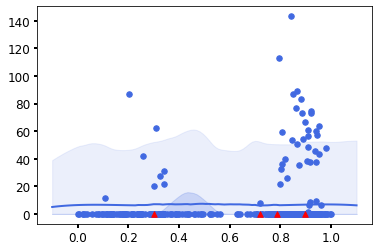

Pde1a


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:06<00:00,  3.09s/it]

The results for Negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -385.475997                    -385.959710   
Pde1a                     -797.368310                    -807.318243   

         log_likelihood_ratio  
Fam184b              0.483713  
Pde1a                9.949933

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:01<00:00,  1.01it/s]

Fam184b


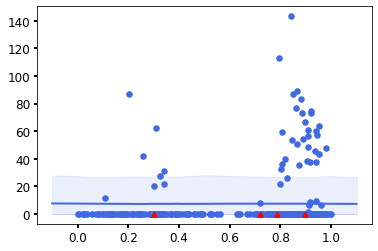

Pde1a


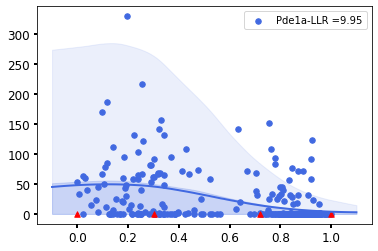

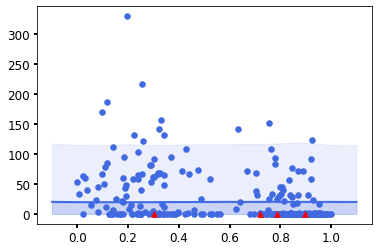

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:02<00:00,  1.04s/it]

The results for Gaussian likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -551.722736                    -554.274225   
Pde1a                     -623.552827                    -663.040243   

         log_likelihood_ratio  
Fam184b              2.551489  
Pde1a               39.487416

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 19.31it/s]

Fam184b


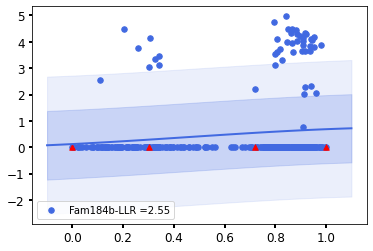

Pde1a


In [9]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],M = 4, sparse = sparse,safe_mode = True) # use sparse inference

for likelihood in likelihoods:
    results = gp_counts.One_sample_test(likelihood)
    print('The results for '+likelihood+' likelihood:')
    display(results)
    params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
    plot(params,X.values,Y.loc[genes_name],results,sparse)


To use kmean algorithm to set the location of inducing points ùëç

$^*$ GPcounts by defaults use $5\%(N^*)$ to set the number of inducing points $M$ if M not specified

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [01:03<00:00, 31.72s/it]

The results for Zero_inflated_negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -374.914879                    -357.566388   
Pde1a                     -767.500143                    -784.107533   

         log_likelihood_ratio  
Fam184b             -17.34849  
Pde1a                16.60739

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:01<00:00,  1.03it/s]

Fam184b


Pde1a


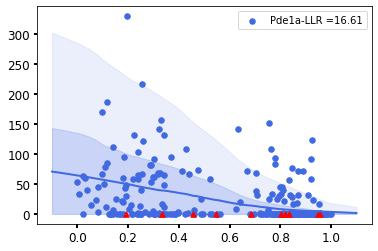

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:06<00:00,  3.42s/it]

The results for Negative_binomial likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -385.560905                    -385.959709   
Pde1a                     -797.366993                    -807.318240   

         log_likelihood_ratio  
Fam184b              0.398804  
Pde1a                9.951248

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:01<00:00,  1.10it/s]

Fam184b


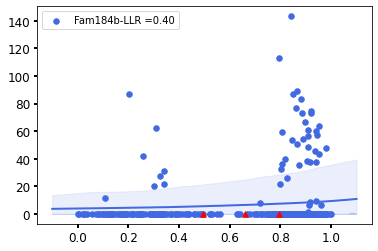

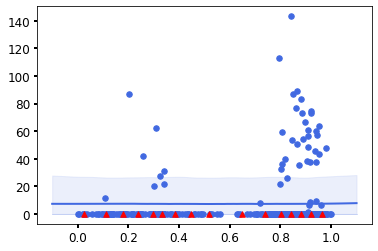

Pde1a


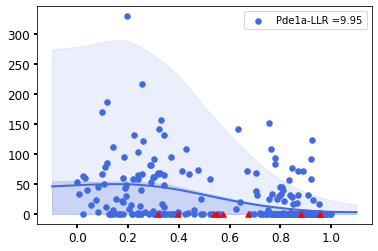

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:02<00:00,  1.04s/it]

The results for Gaussian likelihood:


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Fam184b                   -551.722597                    -554.274207   
Pde1a                     -623.552602                    -663.040234   

         log_likelihood_ratio  
Fam184b              2.551611  
Pde1a               39.487632

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 26.64it/s]

Fam184b


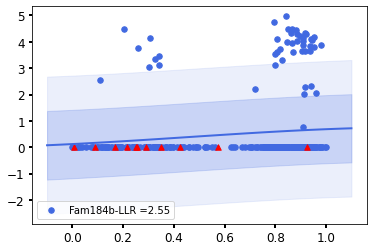

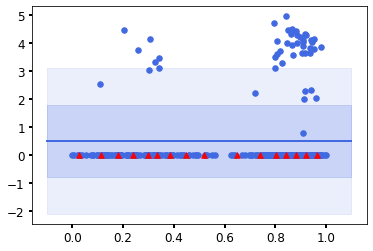

Pde1a


In [10]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],sparse = sparse,safe_mode = True) # use sparse inference
gp_counts.kmean_algorithm_inducing_points( M = 16)

for likelihood in likelihoods:
    results = gp_counts.One_sample_test(likelihood)
    print('The results for '+likelihood+' likelihood:')
    display(results)
    params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
    plot(params,X.values,Y.loc[genes_name],results,sparse)